# Lecture 12:  Numerical Integration and Monte Carlo

**Overview:**
* Numerical integration.
* Simple Monte Carlo integration.
* Importance sampling.

**Next Lecture:**
* Markov chain Monte Carlo and the Metropolis Algorithm.
---

In [3]:
#matplotlib notebook
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import integrate

## Dart Board Estimate of $\pi$

The code in the cell below generates a set of random coordinates inside our unit square and calculates the magnitude of the vector defined by these coordinates.

* Run the code in the cell and call out the number generated for Prof. Plumb to plot on the board.

In [4]:
x = 2 * (np.random.random([1, 2])) - 1
print(np.sqrt(np.sum(x**2)))

0.5512524396761169


### Functions to integrate, and some exact results

In [16]:
def gaussian(x):
    return np.exp(-x**2)

# A Function that is not well behaved 
def Fermi(x):
    num = 1/np.sqrt(x)
    den = np.exp(x)+1
    return num/den

def fp(x):
    arg = 1/(x*(2-x))
    return (np.sin(arg))**2

# area of a unit circle
def sphere(x): 
    """ 
    return 1 if point is inside radius, zero otherwise
    x is a multidimensional vector, must have dimension greater than 1
    """
    r = np.sum(x**2, axis = 1) 
    a = (r<=1).astype(int)
    return 1.0*a

# volume of a hypersphere in n dimensions
hypersphere = lambda r, n: math.pi**(n / 2)/math.gamma(n / 2 + 1)*r**n

# exact integral of a Gaussian
analyticalIntegral = np.sqrt(np.pi)

In [6]:
# Numerically integrate a Gaussian 

def riemannSum(f,a,b):
    top = b
    bottom = a
    width = top - bottom
    n = 100
    dx = width/n
    x = np.arange(bottom, top, width/n)

    return np.sum(f(x)) * dx


def Simpson(f,a,b):
    top = b
    bottom = a
    width = top - bottom
    n = 100
    dx = width/n
    x = np.arange(bottom, top, width/n)
    
    s = (f(-0.5*width)+f(0.5*width)) 
    return (2*f(x[2:-2:2]).sum() + 4*f(x[1:-2:2]).sum()+s) * dx/3

# using Scipy's built in integration schemes
scipyIntegral = integrate.quad(gaussian, -100.0, 100.0)

In [9]:
#np.random.seed(256)
def naiveMonteCarlo(f, limits = [-10,10],d = 1, n_points = 1000, NSamples = 1000):
    """
    Implement a mean value Monte-Carlo Integration in d dimensions
    
    f is function to integrate, must take an input vector x of dimension d
    
    limits define the range of integration, this function only works for integration ranges that are the same
    all dimensitons
    
    n_points are number of points to sample in domain
    NSamples number of time to repeat integration, decrease statistical noise
    """
    width = np.abs(limits[1] - limits[0])
    samples = np.zeros(NSamples)
    
    for i in range(NSamples):
        x = width * (np.random.random([n_points, d])) + limits[0]
        samples[i] = width**d * np.sum(f(x))/n_points    
    
    return samples.mean(), samples.std()

In [10]:
print("Analytical (exact) integral = ", analyticalIntegral)
print("Riemann Sum = ", riemannSum(gaussian))
print("Simpsons Rule = ", Simpson(gaussian))
print("SciPy Integral = ", scipyIntegral)
print("Naive Mean Value Monte Carlo = ", naiveMonteCarlo(gaussian))

Analytical (exact) integral =  1.7724538509055159


TypeError: riemannSum() missing 2 required positional arguments: 'a' and 'b'

### Tasks
* Use the mean value method Monte Carlo method to estimate the value of $\pi$, (area of unit circle) to a higher accuracy than what was done in the demonstration.
* In the cell below, we plot a Pathological function, first examine the plot. Now suppose we wished to determine the value of the integral of this function between x=0 and x=2. Can you evaluate this integral using Simpsons rule or Scipy? Do you expect these results to be accurate? What about using Monte Carlo integration? (the numerical value of the integral should be about 1.45.

#### Estimating $\pi$

In [55]:
naiveMonteCarlo(sphere, limits = [-1,1], d = 2)

(3.1428400000000005, 0.04311582540088967)

#### Pathological Function

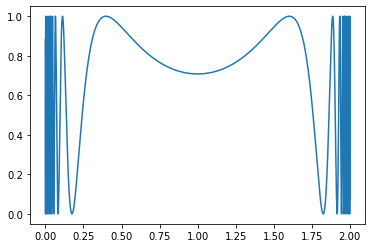

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.linspace(1e-8,2-1e-8,10000)
ax.plot(x,fp(x))

In [54]:
print("Riemann Sum = ", riemannSum(fp,0.000001,2-0.000001))
print("Simpsons Rule = ", Simpson(fp,0.000001,2-0.000001))
#print("SciPy Integral = ", integrate.quad(fp, 0, 2) )
print("Naive Mean Value Monte Carlo = ", naiveMonteCarlo(fp,limits = [0,2]) )

Riemann Sum =  1.396545996955162
Simpsons Rule =  1.4092558880034467
Naive Mean Value Monte Carlo =  (1.4509442512382025, 0.016756788998588613)


### More Tasks
* Use the  Monte Carlo integrator to n-dimensions to find the volume of a hypersphere in 5 dimensions. Compare this results with Simpsons rule and the exact value.
* Can you confirm the error on the MC integration is independent of the number of dimensions?

In [60]:
print("Naive Mean Value Monte Carlo = ", naiveMonteCarlo(sphere, limits = [-1,1], d = 5))
print("True Value = ", hypersphere(1,5))

Naive Mean Value Monte Carlo =  (5.21696, 0.3775309767423065)
True Value =  5.263789013914325


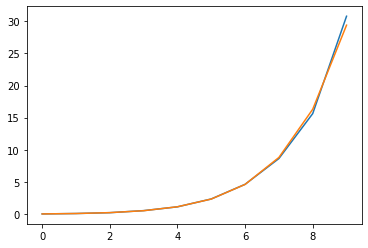

In [144]:
error = np.zeros([10,2])

for i in range(10):
    error[i,0] = naiveMonteCarlo(sphere, limits = [-2,2], d = i)[1]

def F(d):
    return hypersphere(1,d)

def Area(d):
    return 4**d

def SphereError(d):
    return np.sqrt( F(d) * (Area(d)-F(d)) / 1000)

for i in range(10):
    error[i,1] = SphereError(i)
    
plt.plot(range(10), error[:,0])
plt.plot(range(10), error[:,1])

## Importance sampling Monte Carlo
* Review the importance sampling method below. Do you understand all of the steps?
* Can you modify the method and integrate a 4 dimensional Gaussian function?

In [17]:
def p_normal(stdev, x): # normal distribution
    s = 1.0 / stdev
    s2 = s**2
    return np.exp(-s2 * x**2) * s / np.sqrt(np.pi)

def importanceSampledMonteCarlo(f, p, NSamples=10):
    n = 10000
    stdev = 1.0
    samples = np.zeros(NSamples)

    for i in range(NSamples):
        # sample random values from a normal distribution
        x = np.random.normal(loc = 0.0, scale = np.sqrt(0.5) * stdev, size = n)
        samples[i] = (f(x) / p(stdev, x)).mean()       
    
    return samples.mean(), samples.std()


In [18]:
print("Naive Mean Value Monte Carlo = ", naiveMonteCarlo(gaussian))
print("Importance Sampled Monte Carlo = ", importanceSampledMonteCarlo(gaussian, p_normal))

Naive Mean Value Monte Carlo =  (1.773823330965601, 0.14695235061487066)
Importance Sampled Monte Carlo =  (1.7724538509055165, 0.0)


In [29]:
def importanceSampledMonteCarlo4D(f, p, NSamples=10):
    n = 10000
    stdev = 1.0
    samples = np.zeros(NSamples)

    for i in range(NSamples):
        # sample random values from a normal distribution
        x = np.random.normal(loc = 0.0, scale = np.sqrt(0.5) * stdev, size = [4,n])
        w = np.prod(p(stdev,x),axis = 0)
        samples[i] = (np.prod(f(x),axis = 0)/ w).mean()       
    
    return samples.mean(), samples.std()

In [34]:
print("Naive Mean Value Monte Carlo = ", naiveMonteCarlo(gaussian)[0]**4)
print("Importance Sampled Monte Carlo = ", importanceSampledMonteCarlo4D(gaussian, p_normal))

Naive Mean Value Monte Carlo =  10.048746099222525
Importance Sampled Monte Carlo =  (9.869604401089358, 0.0)
